# Regressão em Dados de Seguros

Este notebook apresenta um exemplo prático de regressão aplicada a um conjunto de dados de seguros médicos. O objetivo é mostrar, de forma didática, como preparar os dados, construir pipelines de pré-processamento e treinar modelos preditivos usando o *scikit-learn*.

**Conteúdo abordado:**
- Análise exploratória dos dados
- Separação em treino e teste
- Pré-processamento com pipelines
- Treinamento de modelos de regressão
- Avaliação de desempenho
- Visualização dos resultados
- Modelo em produção

---

## Análise Exploratória Inicial

Vamos iniciar carregando o dataset **insurance.csv** em um *DataFrame* do **pandas**. Dentre os objetivos da análise exploratória inicial estão:

- Verificar o conteúdo do dataset  
- Identificar o formato das *features*  
- Contar o número de instâncias  
- Avaliar a existência de dados faltantes  

### Verificação de consistência dos dados
Com os métodos `.head()` e `.info()` observamos que não há dados faltantes. Além disso, o dataset possui **6 features**, sendo **3 numéricas** (`age`, `bmi`, `children`) e **3 categóricas** (`sex`, `smoker`, `region`) , além do **target**, representado por `charges`.

Por meio do método `.describe()`, obtemos uma **descrição estatística inicial** das variáveis numéricas, incluindo métricas como **média** e **desvio padrão**.

### Histogramas e Contagem de Valores
O método `.hist()` nos dá os histogramas com a distribuição dos valores das variáveis numéricas. Já o método `.value_counts()` nos fornece a contagem de valores para cada feature categórica.

Essas visualizações nos permitem identificar **padrões gerais**, como simetria ou assimetria, presença de caudas longas e possíveis concentrações de dados em determinados intervalos.
 

In [1]:
### ANÁLISE EXPLORATÓRIA INICIAL ###

import pandas as pd
import numpy as np

# Importar dados
dataset_path = "insurance.csv" # Dados já estão na mesma pasta do notebook
insurance = pd.read_csv(dataset_path) 

# Análise inicial dos dados
print(insurance.head()) # Notar quantidade de features categóricos e númericos
print(insurance.info()) # Notar que não há valores faltantes
print(insurance.describe()) 

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000 

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

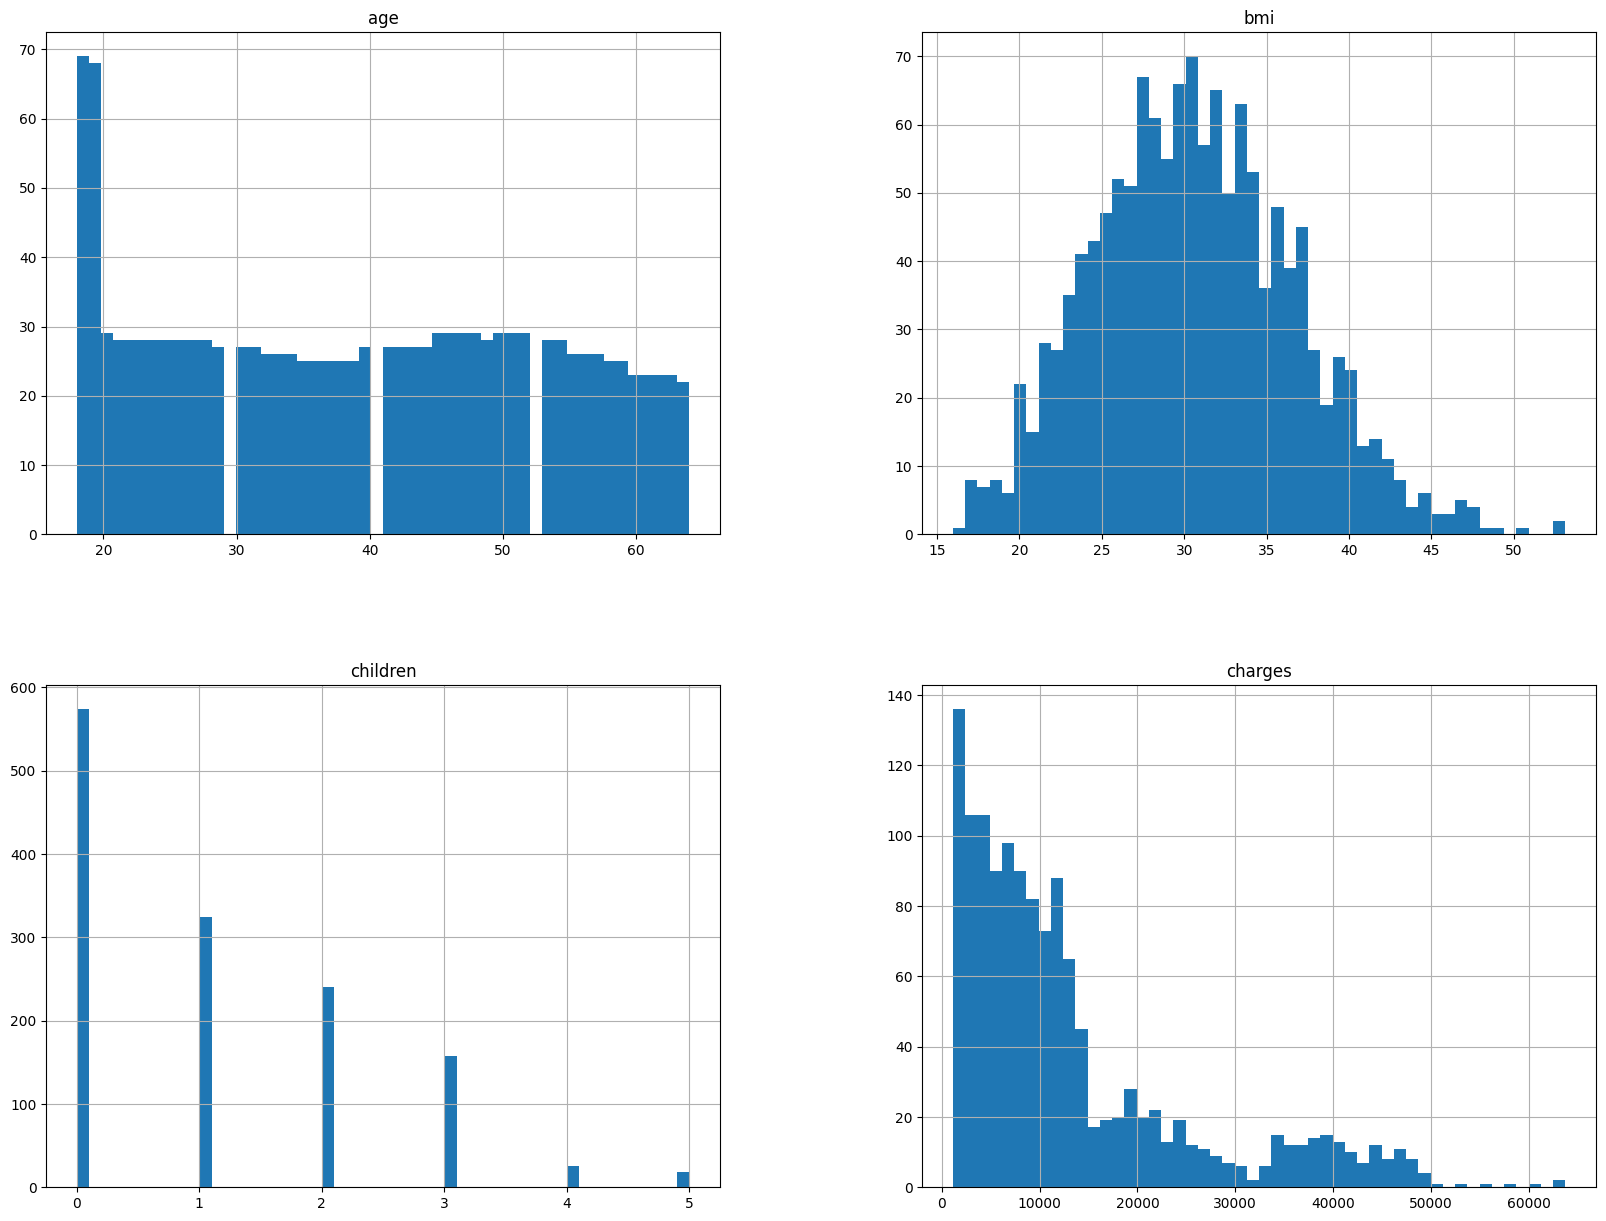

In [ ]:
### ANÁLISE EXPLORATÓRIA INICIAL ###

# Visualização inicial dos dados
insurance.hist(bins=50, figsize=(20,15)) 
# Notar desbalanceamento em dados de idade (possível cap na idade mínima)
# Notar distribuição desbalanceada em charges, o que não é ideal para uma regressão linear simples. (Cauda pode fazer hiperplano se ajustar mal aos dados mais comuns)

insurance["region"].value_counts() # Notar que há 4 regiões, com quantidade similar de dados.

# Separação Treinamento/Teste

Para avaliar o desempenho do modelo de forma imparcial, é necessário dividir o dataset em dois subconjuntos:

- **Treinamento:** utilizado para ajustar os parâmetros do modelo.  
- **Teste:** utilizado exclusivamente para validar o modelo em dados não vistos.

Utilizamos a função `train_test_split()` do *scikit-learn*, definindo uma proporção de 80% dos dados para treinamento e 20% para teste.

Além disso, para cada conjunto, também separamos a matriz de features **X** da coluna de target **y**.

In [3]:
### SEPARAÇÃO TREINAMENTO/TESTE ###

# Usando sklearn
from sklearn.model_selection import train_test_split

insurance_train, insurance_test = train_test_split(insurance, test_size=0.2, random_state=42)
insurance_train.info()

# Separação atributos/labels
insurance_train_X = insurance_train.drop(columns=["charges"]) # X == Atributos, y == Labels
insurance_train_y = insurance_train["charges"]

insurance_test_X = insurance_test.drop(columns=["charges"])
insurance_test_y = insurance_test["charges"]

<class 'pandas.core.frame.DataFrame'>
Index: 1070 entries, 560 to 1126
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   sex       1070 non-null   object 
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   object 
 5   region    1070 non-null   object 
 6   charges   1070 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 66.9+ KB


## Análise Exploratória no Conjunto de Treinamento

Uma vez feita a separação, é possível conduzir uma análise exploratória mais profunda no conjunto de treinamento, sem que haja risco de **vazamento de informação** do conjunto de teste.  

Em nossa análise utilizamos ferramentas como:  
- **Matriz de correlações**, para avaliar relações lineares entre variáveis numéricas.  
- **Scatter plots**, úteis para observar padrões, tendências e possíveis outliers.  
- **Boxplots**, que destacam a dispersão e valores extremos nas variáveis.  
- **Tabelas de contingência**, que permitem examinar a distribuição conjunta de variáveis categóricas.  

O uso dessas técnicas é importante para identificar quais *features* são mais relevantes para o treinamento, compreender interações que podem ser vantajosas de serem incluídas e orientar o processo de ***feature engineering***.

In [4]:
### ANÁLISE EXPLORATÓRIA NO CONJUNTO DE TREINAMENTO ###

# Correlação
insurance_train_num = insurance_train.drop(columns=["smoker","region","sex"]) # Apenas atributos numéricos
corr_matrix = insurance_train_num.corr()
print(corr_matrix)  

# Notar correlação razoavelmente alta entre idade e charges, e entre bmi e charges. Já children e charges tem correlação relativamente baixa. Isso pode ser um indicativo de quais variáveis tendem a ser mais importantes para o modelo e quais podem ser descartadas sem grande perdas. (Contudo, cuidado com relações não lineares!)
# Multicolinearidade -> dificulta interpretação do modelo.

               age       bmi  children   charges
age       1.000000  0.118274  0.060999  0.281721
bmi       0.118274  1.000000 -0.005040  0.197316
children  0.060999 -0.005040  1.000000  0.071885
charges   0.281721  0.197316  0.071885  1.000000


<Axes: xlabel='children', ylabel='charges'>

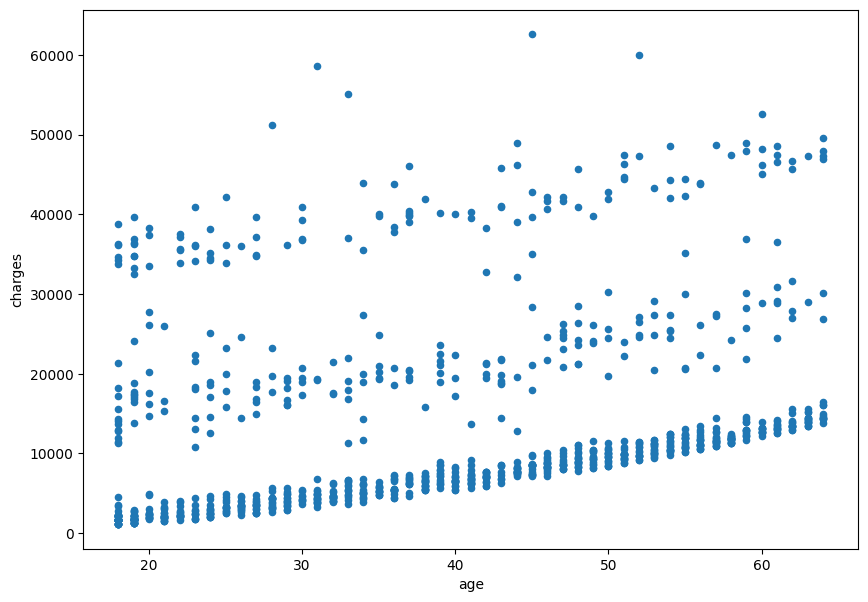

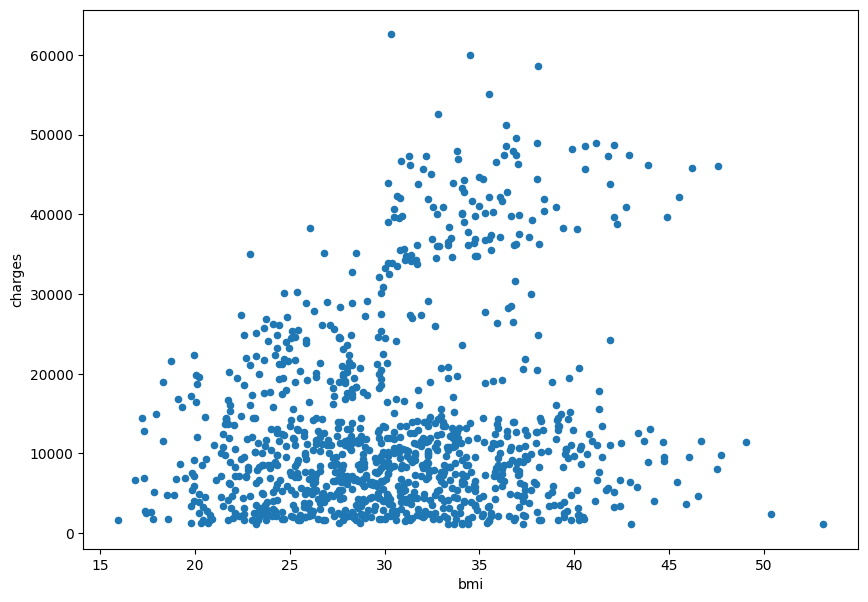

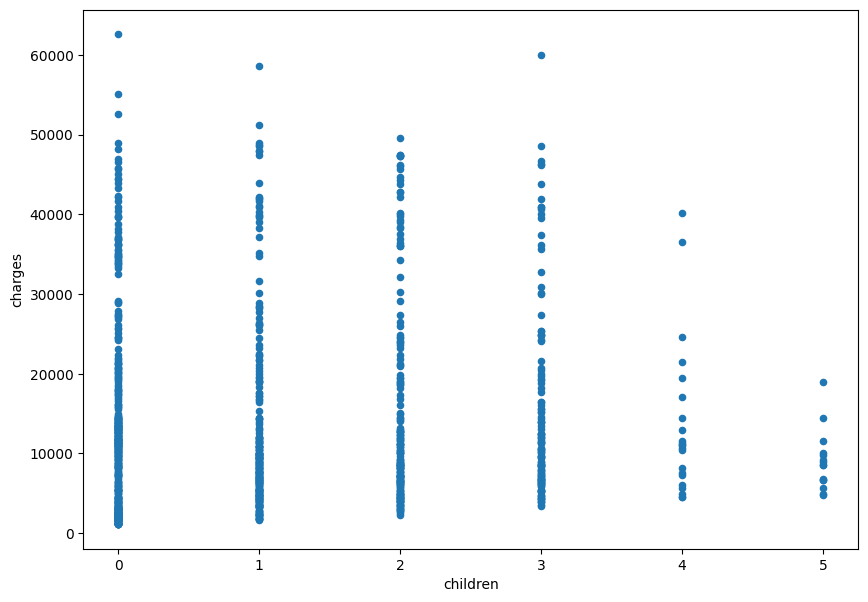

In [5]:
### ANÁLISE EXPLORATÓRIA NO CONJUNTO DE TREINAMENTO ###

# Scatter plots
insurance_train.plot(kind='scatter', x='age', y='charges', figsize=(10,7)) # Mostra relações escondidas, possivelmente devido ao tabagismo e IMC/Dependentes
insurance_train.plot(kind='scatter', x='bmi', y='charges', figsize=(10,7)) # Relativamente poucos charges altos em IMCs baixos (<30).
insurance_train.plot(kind='scatter', x='children', y='charges', figsize=(10,7)) # Não se nota um padrão tão claro pelo scatter plot

sex     female  male
smoker              
no         430   420
yes         92   128


<Axes: title={'center': 'charges'}, xlabel='smoker'>

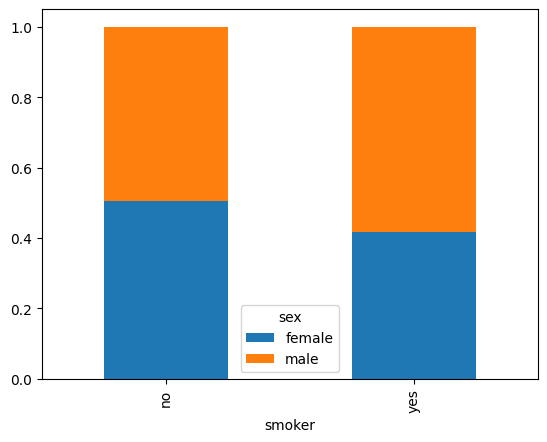

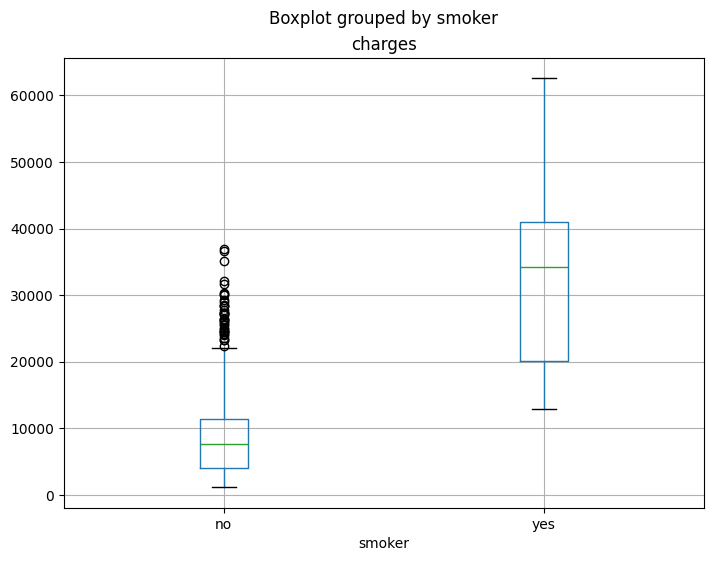

In [6]:
### ANÁLISE EXPLORATÓRIA NO CONJUNTO DE TREINAMENTO ###

# Tabela de contingência
print(pd.crosstab(insurance_train["smoker"], insurance_train["sex"]))
pd.crosstab(insurance_train["smoker"], insurance_train["sex"], normalize='index').plot(kind='bar', stacked=True) 
# Maior prevalência de fumantes entre homens. Categorias sex e smoker não são independentes. Isso indica que pode ser interessante criar interações entre essas categorias.

# Box plots
insurance_train.boxplot(column='charges', by='smoker', figsize=(8,6)) 
# Não fumantes que pagam mais são excessões (outliers) representados pelas bolinhas. Outliers podem influenciar negativamente no modelo.

### Pipeline de Transformações

Após a análise exploratória, estruturamos um fluxo de pré-processamento para preparar os dados antes do treinamento do modelo. Esse fluxo é implementado através de um **pipeline de transformações**, que assegura que as mesmas etapas sejam aplicadas de forma consistente tanto no conjunto de treinamento quanto no de teste. 

O pipeline desenvolvido abaixo inclui:  
- `StandardScaler()` para **features numéricas**, com o objetivo de centralizar e normalizar os valores, evitando que diferenças de escala prejudiquem o ajuste do modelo.  
- `OneHotEncoder()` para **features categóricas**, convertendo categorias em variáveis binárias, o que possibilita o seu manejo matemático.  
- `PolynomialFeatures()` para a feature **age**, com o intuito de capturar possíveis relações não lineares entre a idade e o target (`charges`).

No código, o pipeline é construído combinando transformações específicas para diferentes features. Para isso, utiliza-se o `ColumnTransformer()`, que permite aplicar procedimentos distintos a subconjuntos de colunas do *DataFrame*.

In [7]:
### PIPELINE DE TRANFORMAÇÕES ###

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

# Pipeline de pré-processamento

num_age_col = ["age"] # vamos aplicar polinômio de grau 2 só em age
num_other_cols = ["bmi","children"] # outras numéricas
cat_cols = ["smoker","region","sex"] # categóricas

# Pipelines de cada coluna
age_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False))  
]) # [age, age^2] escalados

num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()), 
]) # Feature scaling, subtrai a média e divide pelo desvio padrão de cada feature numérica.

cat_pipeline = Pipeline([
    ("one_hot_encoder", OneHotEncoder(drop='first')), 
]) # OneHotEncoding para features categoricas

pre_process_pipeline = ColumnTransformer([
        ("age", age_pipe, num_age_col),
        ("num", num_pipeline, num_other_cols),
        ("cat", cat_pipeline, cat_cols), 
    ]) # Aplica pipeline do age para a coluna age, pipeline numérico para outras colunas numéricas e pipeline categórico para colunas categóricas



### Escolha de Modelo

Após o pré-processamento e a definição do pipeline, avaliamos diferentes algoritmos de regressão.  

O objetivo não é compreender em detalhe o funcionamento interno de cada modelo, mas analisá-los como **caixas-pretas** que recebem as *features* transformadas e retornam previsões para o target.  

O processo segue a mesma lógica para todos os modelos:  
1. O pipeline é treinado no conjunto de **treinamento** com `.fit()`.  
2. As previsões são obtidas sobre o conjunto de **teste** com `.predict()`.  
3. O desempenho é avaliado com métricas de erro como `mean_squared_error`, `mean_absolute_error` e o RMSE calculado a partir do MSE.  
4. A busca pelos melhores **hiperparâmetros** é realizada via `GridSearchCV`, que utiliza validação cruzada para selecionar a configuração que minimiza a função de perda escolhida.  

Os modelos considerados foram os seguintes:  
- **`DummyRegressor`**: usado como *baseline*, sempre prevê estatísticas simples do target (média, mediana ou quantil).  
- **``ElasticNet``**: modelo linear regularizado. 
- **``RandomForestRegressor``**: modelo de árvores de decisão em conjunto.  

Além disso, foi testada uma variação do Random Forest com treinamento no **log do target**, utilizando o `TransformedTargetRegressor`. Nesse caso, o modelo aprende a prever `log(charges)`, e os resultados são reconvertidos para a escala original por meio de `np.exp`. Essa transformação desloca o foco da minimização do erro absoluto para algo mais próximo do **erro percentual**, permitindo um ajuste mais equilibrado ao longo de diferentes faixas de valores do target.  

Na comparação entre os modelos, observamos uma tendência de **redução gradual das métricas de erro consideradas**.

In [8]:
### ESCOLHA DE MODELO - Dummy ###

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

# Pipeline Completo: pré-processamento + modelo
dummy_pipeline = Pipeline([
    ("preprocessing", pre_process_pipeline),
    ("dummy", DummyRegressor())
])

# Testar mean, median e quantile
param_grid = [
    {"dummy__strategy": ["mean"]},
    {"dummy__strategy": ["median"]},
    {"dummy__strategy": ["quantile"], "dummy__quantile": [0.25, 0.5, 0.75]}
]

# GridSearchCV (métrica: RMSE)
grid = GridSearchCV(
    estimator=dummy_pipeline,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # Problema de maximização
    cv=5,
)

# Treinar só no conjunto de treinamento
grid.fit(insurance_train_X, insurance_train_y)

# Melhor conjunto de hiperparâmetros encontrado
best_dummy = grid.best_estimator_
print("Melhores hiperparâmetros (dummy):", grid.best_params_)
print(f"RMSE médio (CV, dummy): {-grid.best_score_:.2f}")

# Avaliar no conjunto de teste
pred_dummy = best_dummy.predict(insurance_test_X)
mse  = mean_squared_error(insurance_test_y, pred_dummy)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(insurance_test_y, pred_dummy)
print(f"RMSE (teste, dummy): {rmse:.2f}")
print(f"MAE  (teste, dummy): {mae:.2f}")

Melhores hiperparâmetros (dummy): {'dummy__strategy': 'mean'}
RMSE médio (CV, dummy): 12014.72
RMSE (teste, dummy): 12465.61
MAE  (teste, dummy): 9593.34


In [9]:
### ESCOLHA DE MODELO - Elastic Net ###

from sklearn.linear_model import ElasticNet

# Pipeline Completo: pré-processamento + modelo
enet_pipeline = Pipeline([
    ("preprocessing", pre_process_pipeline),
    ("elastic_net", ElasticNet(max_iter=10000))
])

# Grade de hiperparâmetros
param_grid = {
    "elastic_net__alpha":    [0.001, 0.01, 0.1, 1.0, 10.0],
    "elastic_net__l1_ratio": [0.1, 0.5, 0.9]
}

# GridSearchCV (métrica: RMSE)
grid = GridSearchCV(
    estimator=enet_pipeline,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
)

# Treinar só no conjunto de treinamento
grid.fit(insurance_train_X, insurance_train_y)

# Melhor conjunto de hiperparâmetros encontrado
best_enet = grid.best_estimator_
print("Melhores hiperparâmetros:", grid.best_params_)
print(f"RMSE médio (CV, enet): {-grid.best_score_:.2f}")

# Avaliar no conjunto de teste
predictions = best_enet.predict(insurance_test_X)
mse  = mean_squared_error(insurance_test_y, predictions)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(insurance_test_y, predictions)
print(f"RMSE (teste, enet): {rmse:.2f}")
print(f"MAE  (teste, enet): {mae:.2f}")

Melhores hiperparâmetros: {'elastic_net__alpha': 0.001, 'elastic_net__l1_ratio': 0.5}
RMSE médio (CV, enet): 6124.11
RMSE (teste, enet): 5760.62
MAE  (teste, enet): 4098.76


In [10]:
### ESCOLHA DE MODELO - Random Forest ###

from sklearn.ensemble import RandomForestRegressor

# Pipeline completo: pré-processamento + modelo
rf_pipeline = Pipeline([
    ("preprocessing", pre_process_pipeline),
    ("randforest", RandomForestRegressor(random_state=42))
])

# Grade simples de hiperparâmetros
param_grid = {
    "randforest__n_estimators": [100, 200],
    "randforest__max_depth": [10, 20],
    "randforest__max_features": ["sqrt", "log2"],
}

# GridSearchCV (métrica: RMSE)
grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # RMSE (negativo)
    cv=5,
)

# Treinar só no conjunto de treinamento
grid.fit(insurance_train_X, insurance_train_y)

# Melhor pipeline após a busca
best_rf = grid.best_estimator_
print("Melhores hiperparâmetros (RF):", grid.best_params_)
print(f"RMSE médio (CV, RF): {-grid.best_score_:.2f}")

# Avaliar no conjunto de teste
predictions = best_rf.predict(insurance_test_X)
mse  = mean_squared_error(insurance_test_y, predictions)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(insurance_test_y, predictions)
print(f"RMSE (teste, RF): {rmse:.2f}")
print(f"MAE  (teste, RF): {mae:.2f}")

Melhores hiperparâmetros (RF): {'randforest__max_depth': 10, 'randforest__max_features': 'sqrt', 'randforest__n_estimators': 200}
RMSE médio (CV, RF): 4837.30
RMSE (teste, RF): 4531.29
MAE  (teste, RF): 2689.96


In [11]:
### ESCOLHA DE MODELO - Random Forest + Treinamento com Log do erro ###

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

# Pipeline completo: pré-processamento + modelo
rf_pipeline = Pipeline([
    ("preprocessing", pre_process_pipeline),
    ("randforest", RandomForestRegressor(random_state=42))
])

# Aplicar log na saída
model_pipeline = TransformedTargetRegressor(
    regressor=rf_pipeline,
    func=np.log,
    inverse_func=np.exp
) 

# Grade de hiperparâmetros
param_grid = {
    "regressor__randforest__n_estimators": [100, 200],
    "regressor__randforest__max_depth": [10, 20],
    "regressor__randforest__max_features": ["sqrt", "log2"],
}

# GridSearchCV (métrica: RMSE)
grid = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error", 
    cv=5,
)

# Treinar só no conjunto de treinamento
grid.fit(insurance_train_X, insurance_train_y)

# Melhor conjunto de hiperparâmetros encontrado
best_rf_log = grid.best_estimator_
print("Melhores hiperparâmetros (RF_log):", grid.best_params_)
print(f"RMSE médio (CV, RF_log): {-grid.best_score_:.2f}")

# Avaliar no conjunto de teste
predictions = best_rf_log.predict(insurance_test_X)
mse  = mean_squared_error(insurance_test_y, predictions)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(insurance_test_y, predictions)
print(f"RMSE (teste, RF_log): {rmse:.2f}") # Notar que RMSE é maior do que o RF sem log
print(f"MAE  (teste, RF_log): {mae:.2f}")

Melhores hiperparâmetros (RF_log): {'regressor__randforest__max_depth': 10, 'regressor__randforest__max_features': 'sqrt', 'regressor__randforest__n_estimators': 200}
RMSE médio (CV, RF_log): 4969.86
RMSE (teste, RF_log): 4552.29
MAE  (teste, RF_log): 2199.26


### Visualização das Previsões

Para melhor compararmos o comportamento das previsões de cada modelo podemos construir gráficos com o auxílio da biblioteca **`matplotlib.pyplot`**.

Abaixo foram construídas duas visualizações simples:

1) O **target real** de cada amostra do **conjunto de testes** foi plotado contra o **valor previsto** por cada modelo. A linha de referência tracejada representa uma previsão perfeita.  
2) Os valores reais do **scatterplot do target `charges` vs. a feature `ages`**, sobrepostos à **nuvem de previsões** de cada modelo.

Em ambos os gráficos é possível observar que as previsões de modelos que obtiveram **menores erros após o treinamento** de fato se **ajustaram melhor aos dados de teste**.


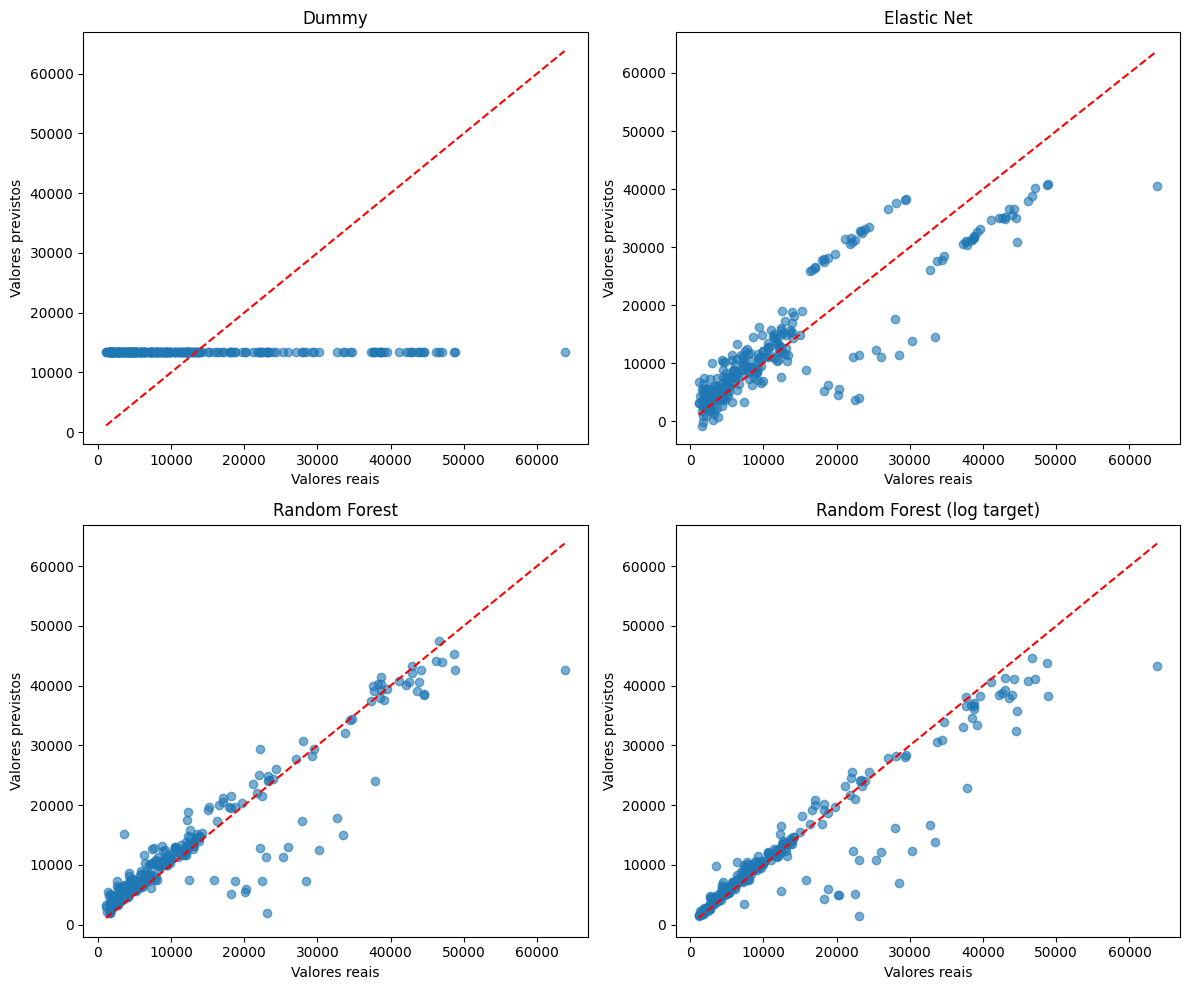

In [12]:
### VISUALIZAÇÃO DAS PREVISÕES ###

import matplotlib.pyplot as plt

# Dicionário com os modelos já treinados e suas previsões
modelos = {
    "Dummy": best_dummy.predict(insurance_test_X),
    "Elastic Net": best_enet.predict(insurance_test_X),
    "Random Forest": best_rf.predict(insurance_test_X),
    "Random Forest (log target)": best_rf_log.predict(insurance_test_X) 
}

# Criar figura com subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# Plot de valores previstos vs reais para cada modelo
for ax, (nome, preds) in zip(axes, modelos.items()):
    ax.scatter(insurance_test_y, preds, alpha=0.6)
    ax.plot([insurance_test_y.min(), insurance_test_y.max()],
            [insurance_test_y.min(), insurance_test_y.max()],
            'r--')
    ax.set_title(nome)
    ax.set_xlabel("Valores reais")
    ax.set_ylabel("Valores previstos")

plt.tight_layout()
plt.show()

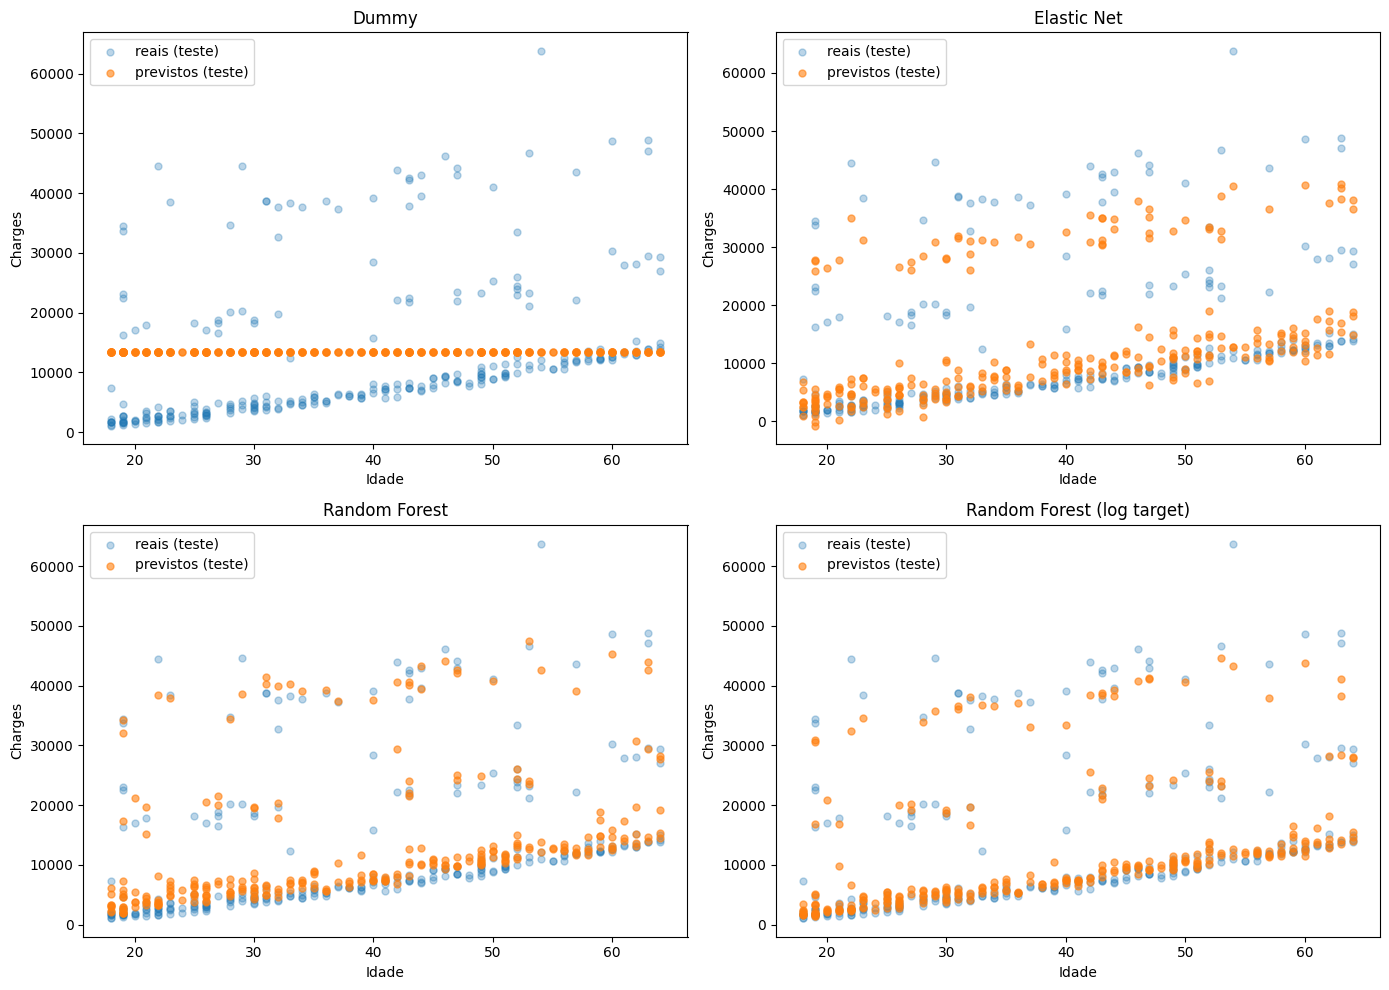

In [13]:
### VISUALIZAÇÃO DAS PREVISÕES ###

# Scatterplot Charges x Ages sobrepondo dados reais e previsões para cada modelo
x_age_test = insurance_test_X["age"].values
y_test = insurance_test_y

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for ax, (nome, y_pred) in zip(axes, modelos.items()):
    ax.scatter(x_age_test, y_test, s=25, alpha=0.3, label="reais (teste)")
    ax.scatter(x_age_test, y_pred, s=25, alpha=0.6, label="previstos (teste)")
    ax.set_title(nome)
    ax.set_xlabel("Idade")
    ax.set_ylabel("Charges")
    ax.legend()

plt.tight_layout()
plt.show()

### Produção

Na etapa de produção, o modelo é treinado novamente com **todos os dados disponíveis**, sem a separação treino/teste. O objetivo não é mais comparar alternativas, mas gerar um modelo final pronto para uso em previsões futuras.

É importante destacar que não se deve ajustar hiperparâmetros com o intuito de diminuir o erro proveniente do conjunto de teste, uma vez que isso pode levar a uma **perda de capacidade de generalização** do modelo frente a dados ainda não vistos.

Finalmente, em um ambiente real de produção, também é fundamental garantir o monitoramento contínuo do desempenho, realizar atualizações periódicas do modelo e tratar corretamente a entrada de novos dados para evitar degradação na qualidade das previsões.

In [14]:
### Produção ###

# Pipeline completo: pré-processamento + modelo final
prod_pipeline = Pipeline([
    ("preprocessing", pre_process_pipeline),
    ("randforest", RandomForestRegressor(
        random_state=42,
        max_depth=10,
        n_estimators=200,
        max_features="sqrt"
    ))
])

# Treinar o pipeline com todos os dados disponíveis
insurance_prod_X = insurance.drop(columns=['charges'])
insurance_prod_y = insurance['charges']

prod_pipeline.fit(insurance_prod_X, insurance_prod_y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age']),
                                                 ('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['smoker', 'region',
                                                   'sex'])])),
                ('randforest',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       n_estimators=200, random_state=42))])